### Corner Detection

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches


#### Load a simple test image of a white squre in a black background. This example image contains only simple edges, corners and uniform regions. 

(-0.5, 116.5, 116.5, -0.5)

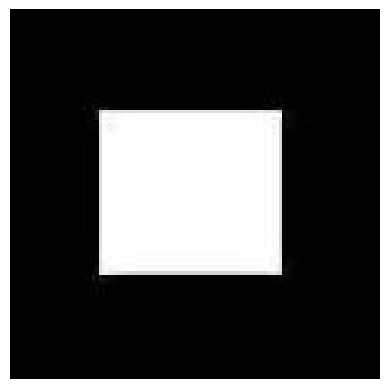

In [359]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = cv2.imread("./square.jpg")
img_rgb = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_gray = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

img_gray = 0.5*(img_gray + 255.0)

plt.imshow(img_gray, cmap='gray')
plt.axis('off')

(-0.5, 116.5, 116.5, -0.5)

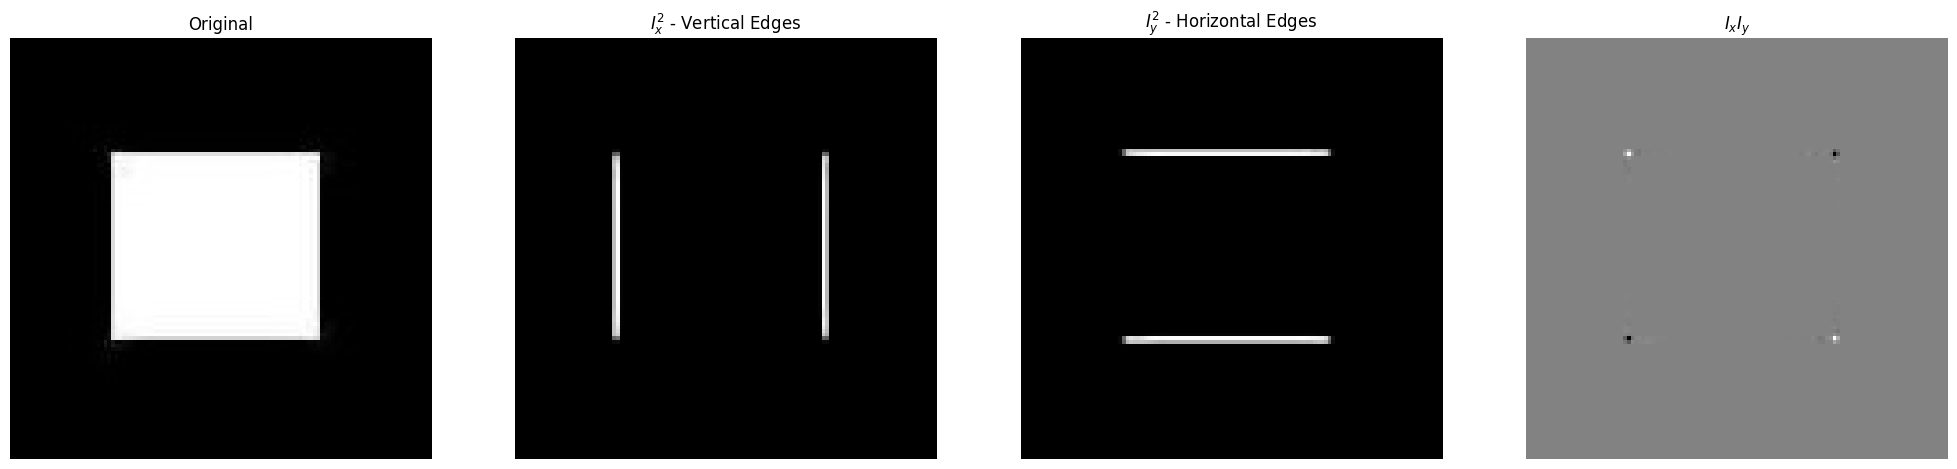

In [373]:
# image derivatiive in x and y directions
Ix = cv2.Sobel(img_gray,-1,1,0,ksize=3)
Iy = cv2.Sobel(img_gray,-1,0,1,ksize=3)

fig,axs = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(25)

plt.subplot(1,4,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(Ix*Ix, cmap='gray')
plt.title('$I_x^2$ - Vertical Edges')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(Iy*Iy, cmap='gray')
plt.title('$I_y^2$ - Horizontal Edges')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(Ix*Iy, cmap='gray')
plt.title('$I_x I_y$')
plt.axis('off')


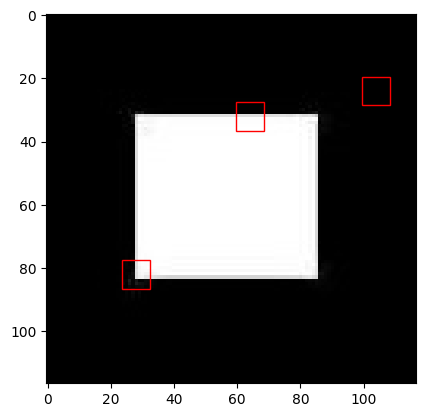

In [368]:
# corner detection window (uniform)
w = np.ones(shape=(9,9)) / (9*9)

# Create windows at the specified pixel coordinates
x1, y1 = 24, 78 
square1 = patches.Rectangle((x1-0.5, y1-0.5), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')
x2, y2 = 60, 28
square2 = patches.Rectangle((x2-0.5, y2-0.5), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')
x3, y3 = 100, 20
square3 = patches.Rectangle((x3-0.5, y3-0.5), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')

# show the image
plt.imshow(img_gray, cmap='gray')
# overlay a red square centered at (x,y)
plt.gca().add_patch(square1)
plt.gca().add_patch(square2)
plt.gca().add_patch(square3)

In [371]:
# computes autocorrelation matrix for window centered at pos 
def compute_M(Ix, Iy, w, pos):
    x, y = pos
    wy = w.shape[0]
    wx = w.shape[1]

    w2 = int(wy/2)
    Ix_padded = np.zeros(shape=(Ix.shape[0]+2*w2, Ix.shape[1]+2*w2)) 
    Iy_padded = np.zeros_like(Ix_padded) 
    Ix_padded[w2:w2+Ix.shape[0], w2:w2+Ix.shape[1]] = Ix 
    Iy_padded[w2:w2+Iy.shape[0], w2:w2+Iy.shape[1]] = Iy 


    Ixx = 0.0
    Iyy = 0.0
    Ixy = 0.0
    #print(f"pos: {pos}")

    for i in range(wy):
        for j in range(wx):
            yp = y-int(wy/2)+i
            xp = x-int(wx/2)+j
            #print(f"i: {i}, j: {j}")
            #print(f"xp; {xp}, yp: {yp}")
            Ixx += w[i,j] * Ix_padded[yp, xp]**2 
            Iyy += w[i,j] * Iy_padded[yp, xp]**2 
            Ixy += w[i,j] * Ix_padded[yp, xp] * Iy_padded[yp, xp]
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
 
    return M    

#### We place windows around 3 different regions: 1) corner region,  2) edge region and 3) uniform region

#### Then we compute the auto-correlation matrix for each window and then look at the eigenvalues

In [372]:
pos1 = (24, 78) # corner region
M1 = compute_M(Ix, Iy, w, pos1)

pos2 = (60, 28) # edge region
M2 = compute_M(Ix, Iy, w, pos2)

pos3 = (100, 20) # uniform region
M3 = compute_M(Ix, Iy, w, pos3)

# eighenvalues of M1, M2 and M3
lambda_M1 = np.linalg.eigvals(M1)
lambda_M2 = np.linalg.eigvals(M2)
lambda_M3 = np.linalg.eigvals(M3)

print(f"Eigenvalues of M in corner region: {lambda_M1}")
print(f"Eigenvalues of M in edge region: {lambda_M2}")
print(f"Eigenvalues of M in uniform region: {lambda_M3}")


Eigenvalues of M in corner region: [1.38396241 0.22097586]
Eigenvalues of M in edge region: [0.         0.44444444]
Eigenvalues of M in uniform region: [0. 0.]


#### For the window containing the corner region, located at pixel coordinates (24, 78), the eigenvalues of M are $\lambda_1 = 1.38$ and $\lambda_2 = 0.22$. 

#### In contrast, for the windows containing the edge region,  $\lambda_1 = 0$ and $\lambda_2 = 0.44$, i.e. $\lambda_2 >> \lambda_1$. And for the uniform region,  $\lambda_2 \approx \lambda_1 \approx 0$.

#### So if the window contains a corner, then we can expect both eigenvalues to be large, otherwise both eigenvalues will be small or there will be large discrepency between them. 

#### Can design a "corner response function" that make use of these effects, e.g. the Harris reponse function which is defined as: 

#### $R = \lambda_1 \lambda_2 - k (\lambda_1 + \lambda_2)^2 = det(M) - k (tr(M))^2$, where k is an empirically chosen constant ($0.04 \le k \le 0.06$) 

#### So, we could slide the window over every position in the image and compute the value of R at each position, if the R value exceeds a threshold,it is likely that the window contains a corner.

In [357]:
def harris_corner_response(M, k=0.04):
    R = np.linalg.det(M) - k * np.trace(M)**2 
    return R

In [365]:
pos1 = (24, 78) # corner region
M1 = compute_M(Ix, Iy, w, pos1)
R1 = harris_corner_response(M1)

pos2 = (60, 28) # edge region
M2 = compute_M(Ix, Iy, w, pos2)
R2 = harris_corner_response(M2)

pos3 = (100, 20) # uniform region
M3 = compute_M(Ix, Iy, w, pos3)
R3 = harris_corner_response(M3)

print(f"R value in corner region: {R1}")
print(f"R value in edge region: {R2}")
print(f"R value in uniform region: {R3}")

R value in corner region: 0.2027892089620485
R value in edge region: -0.007901234567901235
R value in uniform region: 0.0


#### Now lets write a function that creates a corner map for a given image

In [327]:
# computes autocorrelation matrix for window centered at pos 
def compute_M(Ix, Iy, w, pos):
    x, y = pos
    wy = w.shape[0]
    wx = w.shape[1]

    Ixx = 0.0
    Iyy = 0.0
    Ixy = 0.0
  
    for i in range(wy):
        for j in range(wx):
            yp = y - int(wy/2) + i
            xp = x - int(wx/2) + j
            #print(f"i: {i}, j: {j}")
            #print(f"xp; {xp}, yp: {yp}")
            Ixx += w[i,j] * Ix[yp, xp]**2 
            Iyy += w[i,j] * Iy[yp, xp]**2 
            Ixy += w[i,j] * Ix[yp, xp] * Iy[yp, xp]
    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
 
    return M    


def harris_corner_response(M, k=0.04):
    R = np.linalg.det(M) - k * np.trace(M)**2 
    return R


def non_maximal_suppression(img, wsize=5):
    
    w2 = int(wsize/2)
    
    for i in range(w2, img.shape[0]-w2):
        for j in range(w2, img.shape[1]-w2):
            window = img[i-w2:i+w2, j-w2:j+w2]
            maxval = np.max(window)
            window[window < maxval] = 0.0
            img[i-w2:i+w2, j-w2:j+w2] = window         

    return img    


def corner_map(img, window_size = 9, kernel_size=3, thr_p=0.1, threshold=False, non_max_suppression=False):

    # 3x3 sobel filters for computing derivatives
    sobel_x = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]])

    sobel_y = np.array([[1,   2,  1],
                        [0,   0,  0],
                        [-1, -2, -1]])

    # image derivatiive in x and y directions
    #Ix = cv2.filter2D(img, -1, sobel_x)          
    Ix = cv2.Sobel(img,-1,1,0,ksize=kernel_size)
    #Iy = cv2.filter2D(img, -1, sobel_y)  
    Iy = cv2.Sobel(img,-1,0,1,ksize=kernel_size)

    # pad the derivative maps to make them compatible with windowing
    w2 = int(window_size/2)
    Ix_padded = np.zeros(shape=(Ix.shape[0]+2*w2, Ix.shape[1]+2*w2)) 
    Iy_padded = np.zeros_like(Ix_padded) 
    Ix_padded[w2:w2+Ix.shape[0], w2:w2+Ix.shape[1]] = Ix 
    Iy_padded[w2:w2+Iy.shape[0], w2:w2+Iy.shape[1]] = Iy 

    # corner detection window (uniform)
    w = np.ones(shape=(window_size,window_size)) / (window_size**2)

    R = np.zeros_like(img)

    # iterate over each pixel
    for y in range (img.shape[0]):
        for x in range (img.shape[1]):
            pos = (x,y)
            # compute autocorrelation matrix
            M = compute_M(Ix_padded, Iy_padded, w, pos)
            # compute R value
            R[y,x] = harris_corner_response(M)


    # apply threshold (set threshold to 10% of largest response value)
    if threshold:
        thr = np.max(R) * (1- thr_p)
        R[R < thr] = 0.0
        #R[R > thr] = 255.0

    if non_max_suppression:
        R = non_maximal_suppression(R)

    return R


(-0.5, 116.5, 116.5, -0.5)

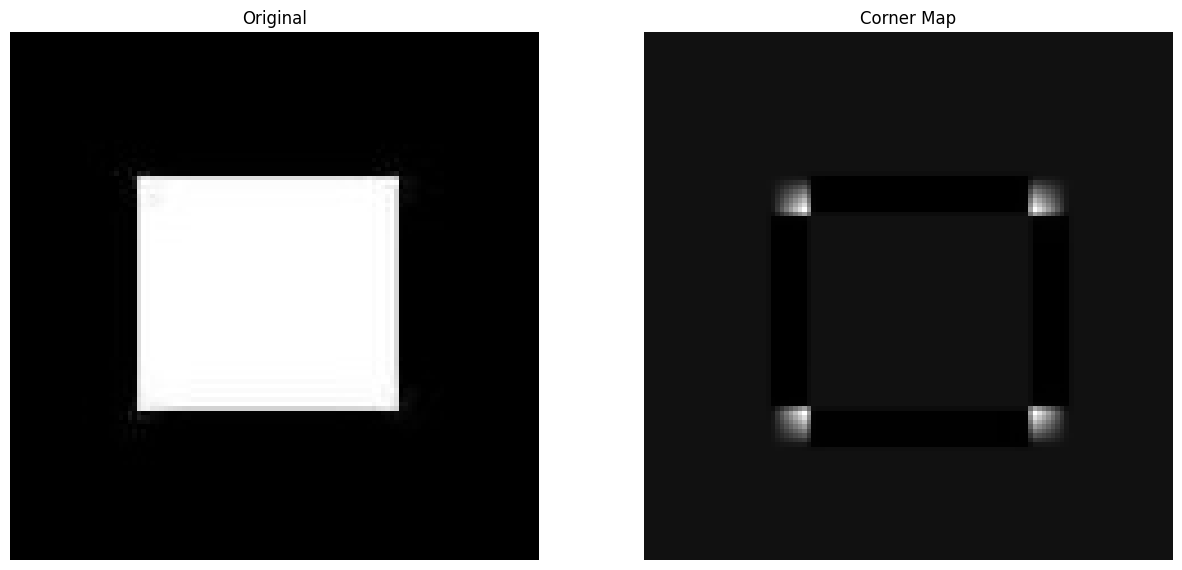

In [302]:
img_corner_map = corner_map(img_gray)

fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corner_map, cmap='gray')
plt.title('Corner Map')
plt.axis('off')

#### The algorithm is able to detect the corners, however, since we used a large window size, the corner region is also large. To mitigate this, we can reduce the window size and/or use non-maximal suppression.

(-0.5, 116.5, 116.5, -0.5)

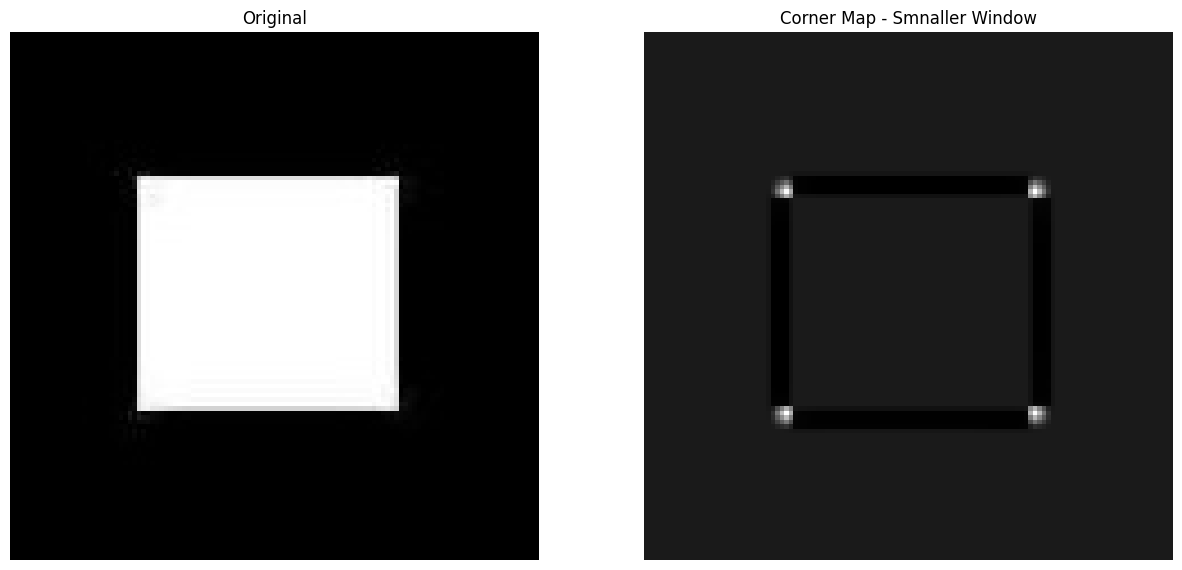

In [303]:
img_corner_map = corner_map(img_gray, window_size=5)


fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corner_map, cmap='gray')
plt.title('Corner Map - Smnaller Window')
plt.axis('off')

(-0.5, 116.5, 116.5, -0.5)

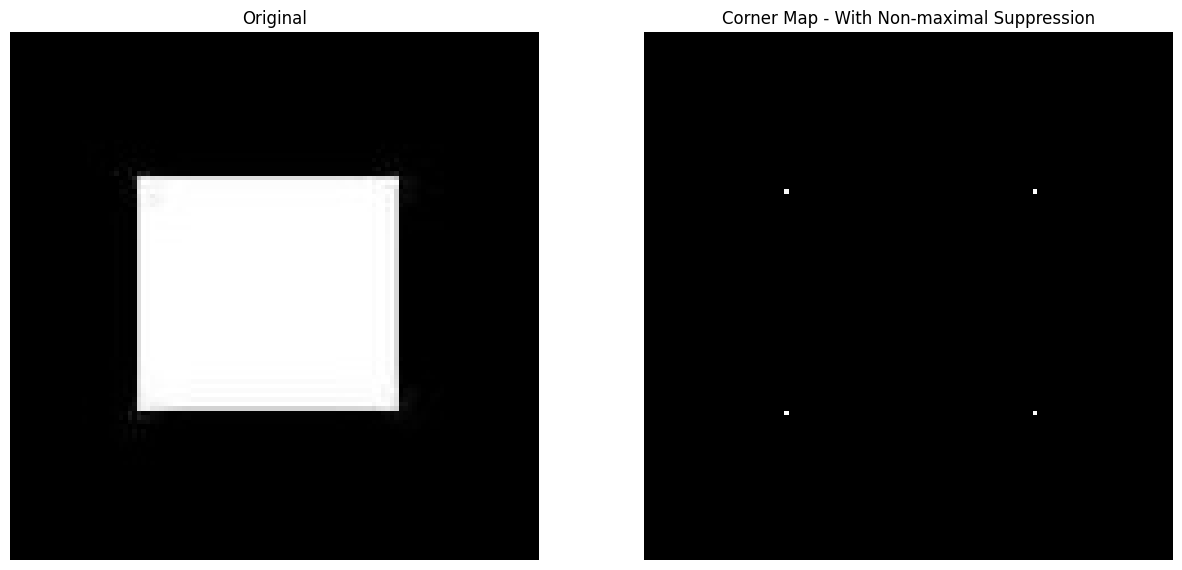

In [308]:
img_corner_map = corner_map(img_gray, window_size=5, non_max_suppression=True)


fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img_gray, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_corner_map, cmap='gray')
plt.title('Corner Map - With Non-maximal Suppression')
plt.axis('off')


#### Now let's try our corner detection algorithm on a different test image

In [409]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = cv2.pyrDown(cv2.pyrDown(cv2.imread("./checkerboard_1.png")))
img_rgb = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img2 = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)).astype('float32')

In [513]:
# a non-maximal suppressions specifically for x and y derivatives of an image
def non_maximal_suppression_grad(Ix, Iy, neighborhood_size=5):

    w = int(neighborhood_size/2)
    
    # apply non maximal suppression to vertical edges, i.e. for each pixel check the two horizontal neighbors, set the pixel to zero if one of the neighbors has higher magnitude
    for i in range(Ix.shape[0]):
        for j in range(Ix.shape[1]):
            lo = max(0,j-w)
            hi = min(j+w, Ix.shape[1]-1) + 1
            maxval = np.max(np.abs(Ix[i,lo:hi]))
            if abs(Ix[i,j]) < maxval:
                Ix[i,j] = 0.0


    # apply non maximal suppression to horizontal edges, i.e. for each pixel check the two vertical neighbors, set the pixel to zero if one of the neighbors has higher magnitude
    for i in range(Iy.shape[0]):
        for j in range(Iy.shape[1]):
            lo = max(0,i-w)
            hi = min(i+w, Iy.shape[1]-1) + 1
            maxval = np.max(np.abs(Iy[lo:hi,j]))
            if abs(Iy[i,j]) < maxval:
                Iy[i,j] = 0.0
    
    return Ix, Iy             

(-0.5, 86.5, 86.5, -0.5)

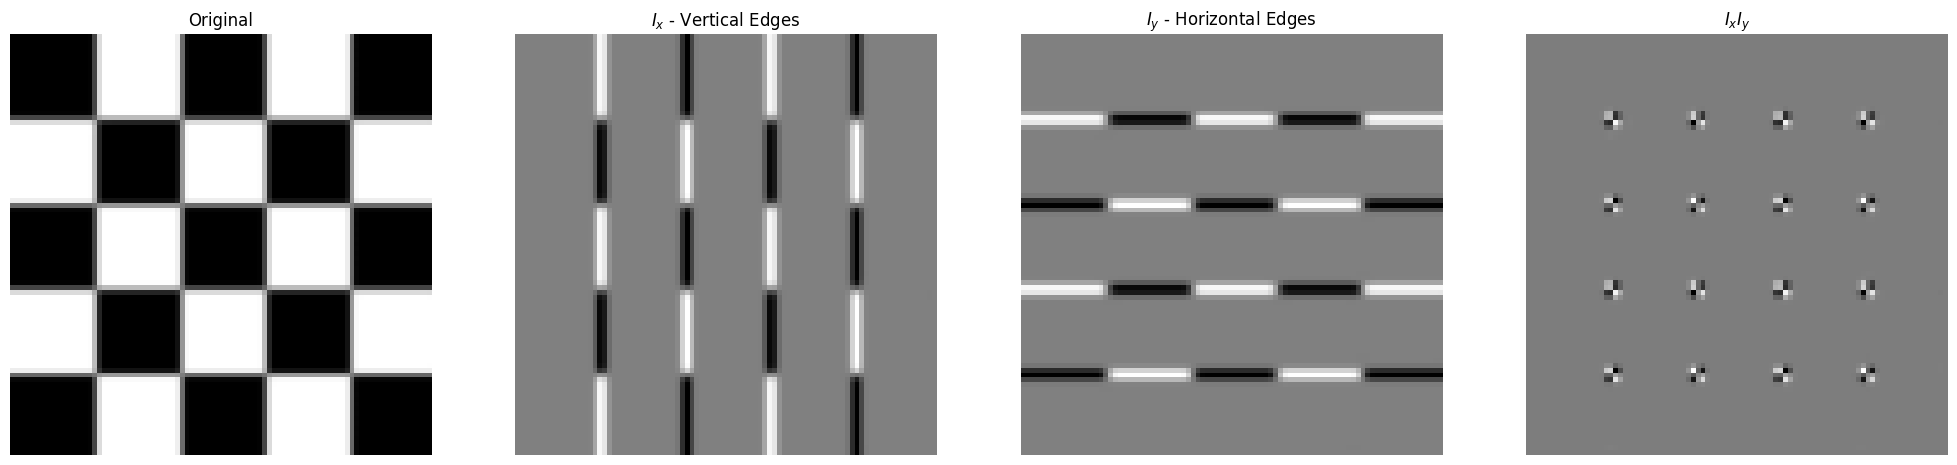

In [462]:
# image derivative in x and y directions
Ix = cv2.Sobel(img2,-1,1,0,ksize=3)
Iy = cv2.Sobel(img2,-1,0,1,ksize=3)

fig,axs = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(25)

plt.subplot(1,4,1)
plt.imshow(img2, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(Ix, cmap='gray')
plt.title('$I_x$ - Vertical Edges')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(Iy, cmap='gray')
plt.title('$I_y$ - Horizontal Edges')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(Ix*Iy, cmap='gray')
plt.title('$I_x I_y$')
plt.axis('off')

(-0.5, 86.5, 86.5, -0.5)

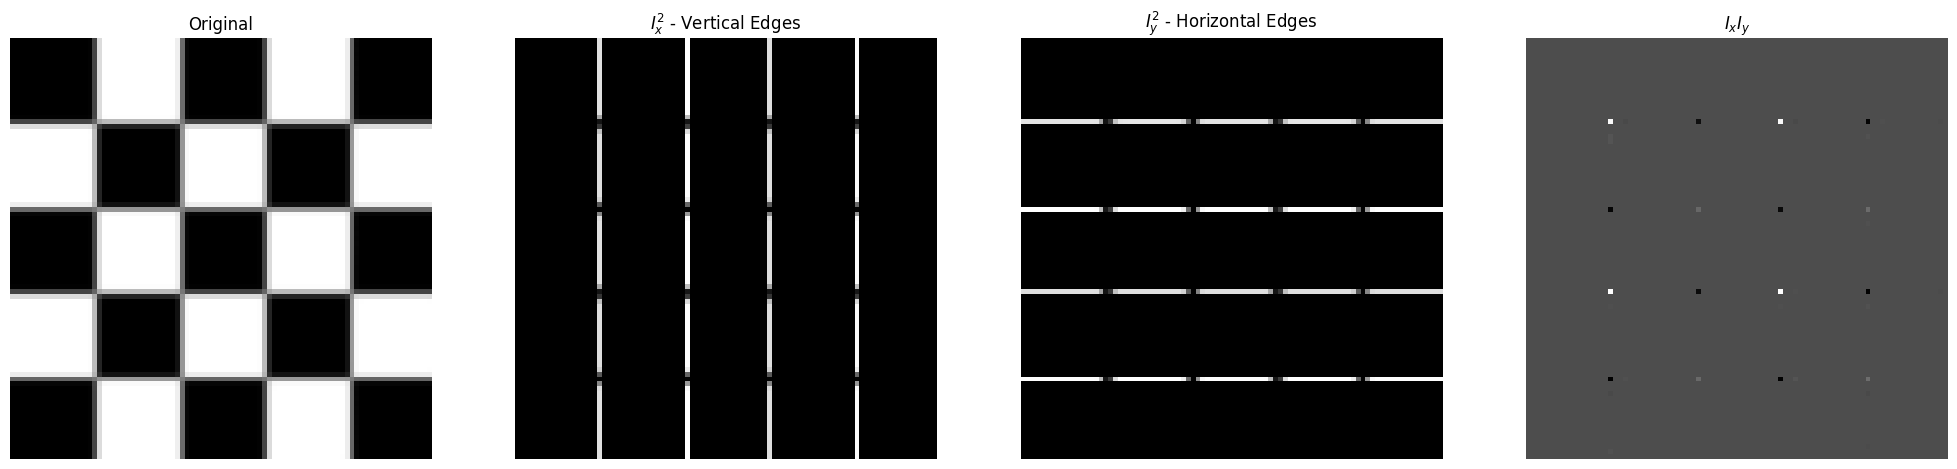

In [467]:
# image derivative in x and y directions
Ix = cv2.Sobel(img2,-1,1,0,ksize=3)
Iy = cv2.Sobel(img2,-1,0,1,ksize=3)

# apply non maximmum suppression to the derivatives
Ix, Iy = non_maximal_suppression_grad(Ix, Iy)

fig,axs = plt.subplots(1,4)
fig.set_figwidth(25)
fig.set_figheight(25)

plt.subplot(1,4,1)
plt.imshow(img2, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(Ix*Ix, cmap='gray')
plt.title('$I_x^2$ - Vertical Edges')
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(Iy*Iy, cmap='gray')
plt.title('$I_y^2$ - Horizontal Edges')
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(Ix*Iy, cmap='gray')
plt.title('$I_x I_y$')
plt.axis('off')

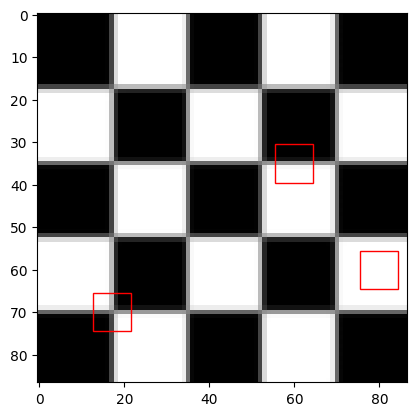

In [512]:
# corner detection window (uniform)
w = np.ones(shape=(9,9)) / (9*9)

# Create windows at the specified pixel coordinates
x1, y1 = 17, 70 
square1 = patches.Rectangle((x1-w.shape[0]/2, y1-w.shape[1]/2), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')
x2, y2 = 60, 35
square2 = patches.Rectangle((x2-w.shape[0]/2, y2-w.shape[1]/2), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')
x3, y3 = 80, 60
square3 = patches.Rectangle((x3-w.shape[0]/2, y3-w.shape[1]/2), w.shape[0], w.shape[1], linewidth=1, edgecolor='r', facecolor='none')

# show the image
plt.imshow(img2, cmap='gray')
# overlay a red square centered at (x,y)
plt.gca().add_patch(square1)
plt.gca().add_patch(square2)
plt.gca().add_patch(square3)

Autocorrelation matrix in corner region: 
[[64664.54320988  -388.22222222]
 [ -388.22222222 73328.83950617]]
Autocorrelation matrix in edge region: 
[[    0.             0.        ]
 [    0.         95687.11111111]]
Autocorrelation matrix in uniform region: 
[[0. 0.]
 [0. 0.]]
Eigenvalues of M in corner region: [64647.18287185 73346.1998442 ], R-value: 3979938247.346466
Eigenvalues of M in edge region: [    0.         95687.11111111], R-value: -366240929.31160486
Eigenvalues of M in uniform region: [0. 0.], R-value: 0.0


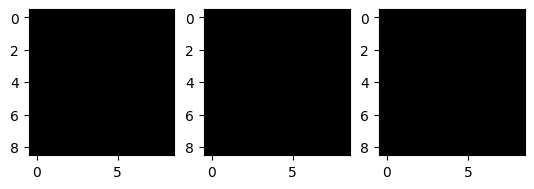

In [514]:
# computes autocorrelation matrix for window centered at pos 
def compute_M(Ix, Iy, w, pos):
    x, y = pos
    wy = w.shape[0]
    wx = w.shape[1]

    w2 = int(wy/2)
    Ix_padded = np.zeros(shape=(Ix.shape[0]+2*w2, Ix.shape[1]+2*w2)) 
    Iy_padded = np.zeros_like(Ix_padded) 
    Ix_padded[w2:w2+Ix.shape[0], w2:w2+Ix.shape[1]] = Ix 
    Iy_padded[w2:w2+Iy.shape[0], w2:w2+Iy.shape[1]] = Iy 

    # offset x,y  after padding
    x = x+w2 
    y = y+w2 


    Ix_patch = Ix_padded[y-int(wy/2):y+int(wy/2)+1, x-int(wx/2):x+int(wx/2)+1]
    Iy_patch = Iy_padded[y-int(wy/2):y+int(wy/2)+1, x-int(wx/2):x+int(wx/2)+1]
    Ixy_patch = Ix_patch * Iy_patch

    plt.subplot(1,3,1)
    plt.imshow(Ix_patch, cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(Iy_patch, cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(Ixy_patch, cmap='gray')
    

    Ixx = np.sum(w * (Ix_patch**2))
    Iyy = np.sum(w * (Iy_patch**2))
    Ixy = np.sum(w * Ixy_patch)

    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
 
    return M    


pos1 = (17, 70) # corner region
M1 = compute_M(Ix, Iy, w, pos1)
R1 = harris_corner_response(M1)

pos2 = (60, 35) # edge region
M2 = compute_M(Ix, Iy, w, pos2)
R2 = harris_corner_response(M2)

pos3 = (80, 60) # uniform region
M3 = compute_M(Ix, Iy, w, pos3)
R3 = harris_corner_response(M3)

# eighenvalues of M1, M2 and M3
lambda_M1 = np.linalg.eigvals(M1)
lambda_M2 = np.linalg.eigvals(M2)
lambda_M3 = np.linalg.eigvals(M3)


print(f"Autocorrelation matrix in corner region: \n{M1}")
print(f"Autocorrelation matrix in edge region: \n{M2}")
print(f"Autocorrelation matrix in uniform region: \n{M3}")

print(f"Eigenvalues of M in corner region: {lambda_M1}, R-value: {R1}")
print(f"Eigenvalues of M in edge region: {lambda_M2}, R-value: {R2}")
print(f"Eigenvalues of M in uniform region: {lambda_M3}, R-value: {R3}")

#### We've implemented a new non maxinmal suppressions for the derivative s and also made some improvements to the window for computing the aucorrelation matrix. Let's use these to make a better corner detector

In [521]:
# computes autocorrelation matrix for window centered at pos 
def compute_M(Ix, Iy, w, pos):
    x, y = pos 
    w2 = int(w.shape[0]/2)

    # offset x,y to compensate for padding
    x = x+w2 
    y = y+w2 

    Ix_patch = Ix[y-w2:y+w2+1, x-w2:x+w2+1]
    Iy_patch = Iy[y-w2:y+w2+1, x-w2:x+w2+1]
    Ixy_patch = Ix_patch * Iy_patch

    Ixx = np.sum(w * (Ix_patch**2))
    Iyy = np.sum(w * (Iy_patch**2))
    Ixy = np.sum(w * Ixy_patch)

    M = np.array([[Ixx, Ixy], [Ixy, Iyy]])
 
    return M    
 

def harris_corner_response(M, k=0.04):
    R = np.linalg.det(M) - k * np.trace(M)**2 
    return R


# a non-maximal suppressions specifically for x and y derivatives of an image
def non_maximal_suppression_grad(Ix, Iy, neighborhood_size=5):

    w = int(neighborhood_size/2)
    
    # apply non maximal suppression to vertical edges, i.e. for each pixel check the two horizontal neighbors, set the pixel to zero if one of the neighbors has higher magnitude
    for i in range(Ix.shape[0]):
        for j in range(Ix.shape[1]):
            lo = max(0,j-w)
            hi = min(j+w, Ix.shape[1]-1) + 1
            maxval = np.max(np.abs(Ix[i,lo:hi]))
            if abs(Ix[i,j]) < maxval:
                Ix[i,j] = 0.0


    # apply non maximal suppression to horizontal edges, i.e. for each pixel check the two vertical neighbors, set the pixel to zero if one of the neighbors has higher magnitude
    for i in range(Iy.shape[0]):
        for j in range(Iy.shape[1]):
            lo = max(0,i-w)
            hi = min(i+w, Iy.shape[1]-1) + 1
            maxval = np.max(np.abs(Iy[lo:hi,j]))
            if abs(Iy[i,j]) < maxval:
                Iy[i,j] = 0.0
    
    return Ix, Iy  


def corner_map(img, window_size = 9, kernel_size=3, thr_p=0.1, threshold=False):

    # image derivatiive in x and y directions
    Ix = cv2.Sobel(img,-1,1,0,ksize=kernel_size)
    Iy = cv2.Sobel(img,-1,0,1,ksize=kernel_size)

    # apply non-maximal suppression to the derivatives
    Ix, Iy = non_maximal_suppression_grad(Ix, Iy)

    # pad the derivatives to make them compatible with windowing
    w2 = int(window_size/2)

    Ix_padded = np.zeros(shape=(Ix.shape[0]+2*w2, Ix.shape[1]+2*w2)) 
    Iy_padded = np.zeros_like(Ix_padded) 
    Ix_padded[w2:w2+Ix.shape[0], w2:w2+Ix.shape[1]] = Ix 
    Iy_padded[w2:w2+Iy.shape[0], w2:w2+Iy.shape[1]] = Iy 

    # corner detection window (uniform)
    w = np.ones(shape=(window_size,window_size)) / (window_size**2)

    R = np.zeros_like(img)

    # iterate over each pixel
    for y in range (img.shape[0]):
        for x in range (img.shape[1]):
            pos = (x,y)
            # compute autocorrelation matrix for window centered at pos
            M = compute_M(Ix_padded, Iy_padded, w, pos)
            # compute R value
            R[y,x] = harris_corner_response(M)


    # apply threshold (set threshold to 10% of largest response value)
    if threshold:
        thr = np.max(R) * thr_p
        R[R < thr] = 0.0
        #R[R > thr] = 255.0

    return R

#### Let's try out the improved corner detector on the test image

(-0.5, 86.5, 86.5, -0.5)

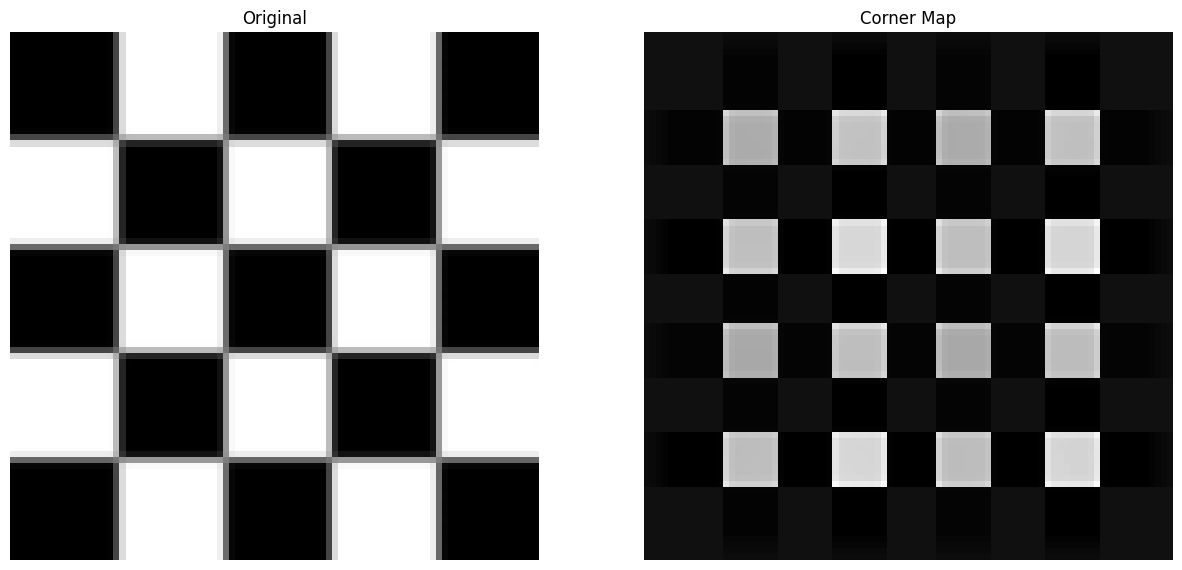

In [522]:
img2_corner_map = corner_map(img2)

fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img2, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_corner_map, cmap='gray')
#plt.colorbar()
plt.title('Corner Map')
plt.axis('off')

#### The window size is very large which is why the detected corner regions are so big. Try decreasing the window size and add thresholding

(-0.5, 86.5, 86.5, -0.5)

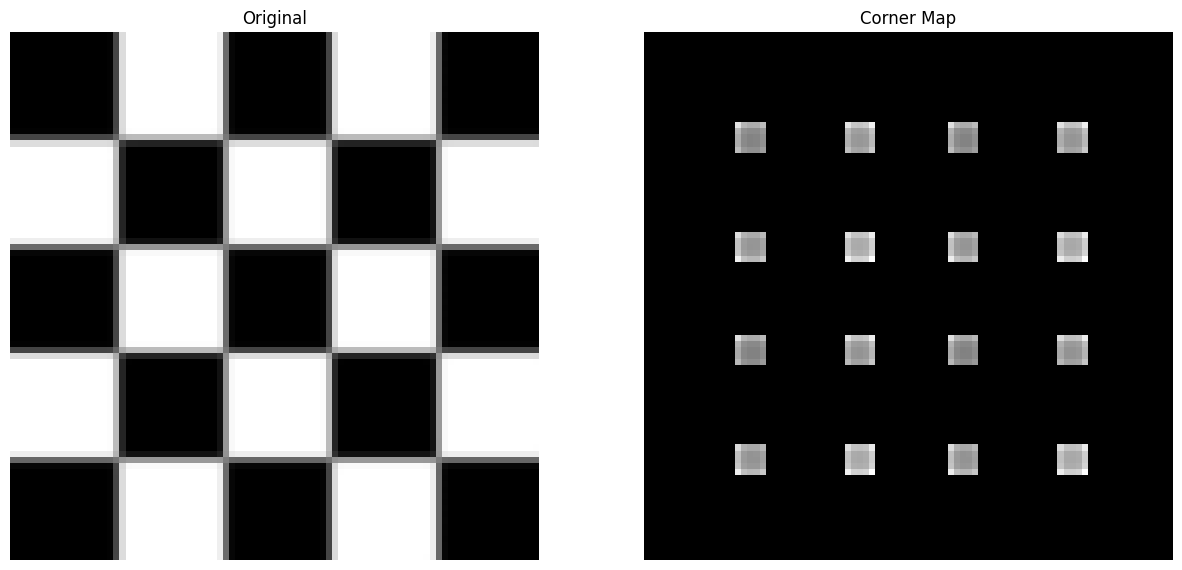

In [529]:
img2_corner_map = corner_map(img2, window_size=5, threshold=True, thr_p=0.5)

fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img2, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img2_corner_map, cmap='gray')
plt.title('Corner Map')
plt.axis('off')

#### Now let's try a higher resolution image

In [532]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img3 = np.array(cv2.imread("./checkerboard.png", cv2.IMREAD_GRAYSCALE)).astype('float32')

(-0.5, 639.5, 639.5, -0.5)

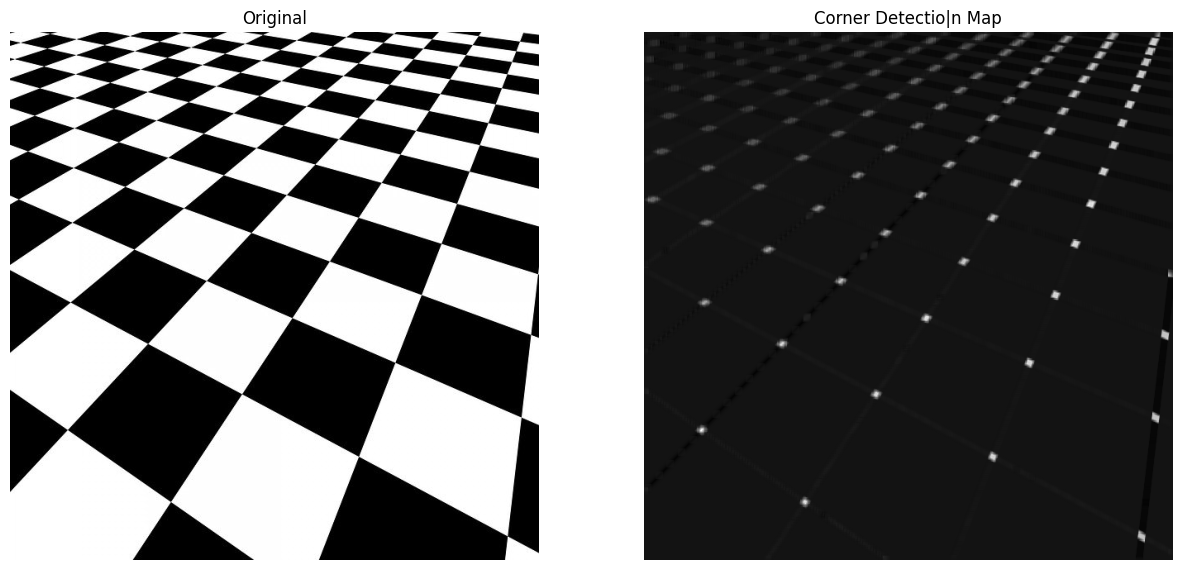

In [535]:
img3_corner_map = corner_map(img3, window_size=9, threshold=False, thr_p=0.5)

fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(15)

plt.subplot(1,2,1)
plt.imshow(img3, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3_corner_map, cmap='gray')
plt.title('Corner Detectio|n Map')
plt.axis('off')